In [1]:
%reload_ext autoreload
#!pip install -r requirements.txt

dataset: soliton
dataset: soliton
64 torch.Size([10, 50])


/var/folders/wb/p5xwlpld3rbb00y719123mvr0000gn/T/ipykernel_44580/3201539858.py:40: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3281.)
  plt.plot(x, trainset[3][t].T, '--', label=f"t={t}")


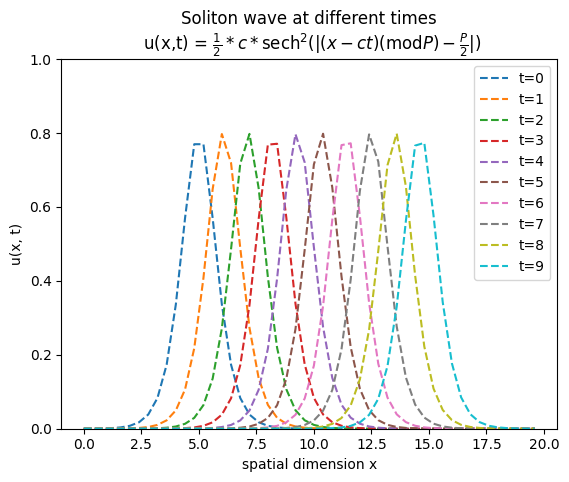

In [2]:
%autoreload
from architectures import COTGAN, COTGAN_general
from utils import DatasetSinus, DatasetSoliton, log_visualizations
from trainer import cotgan_trainer, cotgan_generator, create_dataset, cotgan_trainer_general
from metrics import *
import numpy as np
import torch
import matplotlib.pyplot as plt

seed = 1

np.random.seed(seed)
torch.manual_seed(seed)

device = "cpu"

params_dataset = {
    "dataset": "soliton",
    "P": 20, # period
    "spatial_len": 50, # M
    "t_steps": 10,
    "t_range": [0, 6],
    "c_range": [0.5, 2],
    "difficulty": "easy",
}
if params_dataset["difficulty"] == "medium":
    params_dataset["dataset"] = "medium_soliton"

trainset = create_dataset(dataset=params_dataset["dataset"],n_samples=32*2, p=params_dataset, device=device)
testset  = create_dataset(dataset=params_dataset["dataset"],n_samples=32*2, p=params_dataset)

print(len(testset), trainset[0].shape)
def grid(P, M):
    dx = P/M
    x = torch.linspace(0, P-dx, M)
    return x, dx
x,_ = grid(params_dataset["P"], params_dataset["spatial_len"])
#plt.plot(trainset[0].T);
for t in range(params_dataset["t_steps"]):
    plt.plot(x, trainset[3][t].T, '--', label=f"t={t}")
plt.ylim(0, 1)
u_t_x = r"u(x,t) = $\frac{1}{2} *c* \mathrm{sech}^2 (| (x - c t) (\mathrm{mod}P)-\frac{P}{2}|)$"
plt.title(f"Soliton wave at different times\n {u_t_x}")
plt.xlabel("spatial dimension x")
plt.ylabel("u(x, t)")
plt.legend()

In [4]:

%autoreload
import neptune.new as neptune
from architectures import TimeGAN
"""run = neptune.init_run(
    project="kohmann/COTGAN",
    name="cotgan",
    tags=["soliton"],
    description="",
    source_files=["architectures.py"],
    capture_hardware_metrics=True,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)"""

params = {
    "model_name": "model_timegan.pt",
    "n_epochs": 50,
    "l_rate":   0.001, # for both D and G
    "l_rate_ae": 0.001,
    "num_layers": 2,
    "dis_thresh": 0.15,
    "batch_size": 32,
    "use_opt_scheduler": False,

    "rnn_type": "GRU", # LSTM, GRU
    "dis_rnn_num_layers": 2,
    "dis_rnn_hidden_dim": 64,
    "gen_rnn_num_layers": 2,
    "gen_rnn_hidden_dim": 64,
    "J_dim": 32,
    "hidden_dim": 64, # generator: hidden dim in FC, discriminator: filters in Convolution
    "num_hidden_layers": 3, # generator fully-connected layers
    "use_bn": False, # batch normalization

    "scaling_coef": 1.0, # distance scaling (TODO(Not implemented))
    "reg_lam":      0.01, # martingale penalty coefficient
    "sinkhorn_eps": 10.0, # epsilon regularizer
    "sinkhorn_l":   100, # sinkhorn calculation iterations

    "Z_dim": 10,
    "optimizer": "Adam", # RMSprop, Adam
    "beta1": 0.5,
    "beta2": 0.9,
    "dataset": params_dataset["dataset"], # "soliton" or "sines"
    "feature_dim": trainset[0].size(1),
    "max_seq_len": trainset[0].size(0),
    "trainset_size": len(trainset),
    "testset_size": len(testset),
    "device": device,
}
params = params | trainset.get_params()
#run["parameters"] = params
#run["dataset"] = trainset.get_params()

model = TimeGAN(params)

In [5]:
%autoreload
from trainer import timegan_trainer
#cotgan_trainer(model, trainset, params, val_dataset=testset, neptune_logger=None, continue_training=False)
timegan_trainer(model, trainset, params, neptune_logger=None, continue_training=False)


Start Embedding Network Training


Epoch: 49, Loss: 0.0681: 100%|██████████| 50/50 [00:00<00:00, 57.99it/s]



Start Training with Supervised Loss Only


Epoch: 49, Loss: 0.0552: 100%|██████████| 50/50 [00:00<00:00, 86.66it/s]



Start Joint Training


Epoch: 49, E: 0.3288, G: 2.5988, D: 1.7966: 100%|██████████| 50/50 [00:07<00:00,  6.88it/s]

Training Complete and model_timegan.pt saved


X_size: torch.Size([1, 10, 50])


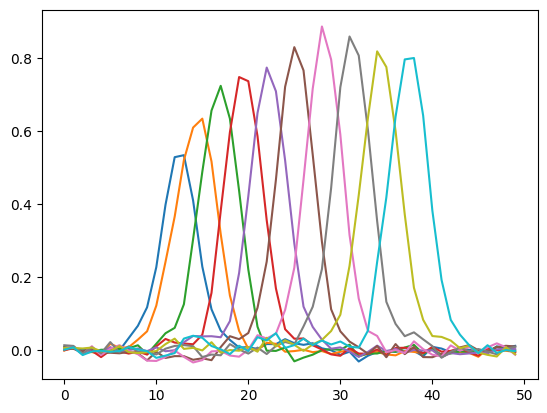

In [6]:
X_hat = model(X=None, Z=torch.randn(1,params["max_seq_len"], params["Z_dim"]), obj="inference")
print(f"X_size: {X_hat.size()}")
plt.plot(X_hat.detach()[0,:,:].T);

In [ ]:

# Generate random synthetic data
gen_z = cotgan_generator(model, params)

log_visualizations(testset, gen_z, run) # log pca, tsne, umap, mode_collapse
run["model_checkpoint"].upload("./models/" + params["model_name"])

from metrics import compare_sin3_generation, sw_approx,two_sample_kolmogorov_smirnov, mae_height_diff

#np.random.seed(seed + 1)
#torch.manual_seed(seed + 1)

testset2 = create_dataset(dataset=params["dataset"], n_samples=params["testset_size"], p=params)
fake_data = cotgan_generator(model, params)

if params["dataset"] == "sines":
    mse_error = compare_sin3_generation(fake_data, 0.7, 0)
    print("ALPHA AND NOISE ARE HARD CODED IN THE METRIC FUNCTION to be 0.7 and 0.")
    run["numeric_results/sin3_generation_MSE_loss"] = mse_error

if "soliton" in params["dataset"]:
    fake = torch.tensor(fake_data)
    c_fake = fake[:, 0,:].max(dim=1)[0]
    c_real = testset[:][:, 0,:].max(dim=1)[0]
    run["numeric_results/c_mode_collapse"] = two_sample_kolmogorov_smirnov(c_real, c_fake)
    if params["difficulty"] == "easy":
        run["numeric_results/height_diff_mae"] = mae_height_diff(fake)
    fig = plt.figure(figsize=(7, 5))
    plt.hist(2.*c_fake, bins=100, density=True)
    plt.xlim(0.5, 2)
    run["c_fake_distribution"].upload(fig)
    plt.close(fig)


n_samples = params["testset_size"]
max_seq_len = fake_data.shape[1]
x = torch.tensor(fake_data).view(n_samples * max_seq_len, -1)
y = testset[:].view(n_samples * max_seq_len, -1)
y_2 = testset2[:].view(n_samples * max_seq_len, -1)

run["numeric_results/num_test_samples"] = len(testset)
run["numeric_results/SW"] = sw_approx(y,x)
run["numeric_results/SW_baseline"] = sw_approx(y,y_2)
run.stop()


# RUN SINUS


--n_epochs 100 --batch_size 32 --l_rate 0.001 --l_rate_g 0.001 --reg_lam 0.01 --sinkhorn_eps 0.8 --dataset sinus --max_seq_len 25 --trainset_size 1536 --testset_size 1536 --gen_rnn_num_layers 2 --gen_rnn_hidden_dim 64 --dis_rnn_num_layers 2 --dis_rnn_hidden_dim 64 --hidden_dim 64 --num_hidden_layers 3 --Z_dim 10 --J_dim 32 --device cpu

# RUN SOLITON

In [ ]:
!python3 trainer.py --n_epochs 40 --batch_size 32 --l_rate 0.001 --l_rate_g 0.001 --reg_lam 0.01 --sinkhorn_eps 0.8 --dataset soliton --spatial_len 50 --t_steps 10 --P 20 --trainset_size 1536 --testset_size 1536 --gen_rnn_num_layers 2 --gen_rnn_hidden_dim 64 --dis_rnn_num_layers 2 --dis_rnn_hidden_dim 64 --hidden_dim 64 --num_hidden_layers 3 --Z_dim 10 --J_dim 32 --device cuda

In [ ]:
!python3 trainer.py --n_epochs 40 --batch_size 32 --l_rate 0.001 --l_rate_g 0.001 --reg_lam 0.01 --sinkhorn_eps 0.8 --dataset soliton --spatial_len 50 --t_steps 10 --P 20 --trainset_size 1536 --testset_size 1536 --gen_rnn_num_layers 2 --gen_rnn_hidden_dim 64 --dis_rnn_num_layers 2 --dis_rnn_hidden_dim 64 --hidden_dim 64 --num_hidden_layers 3 --Z_dim 10 --J_dim 32 --device cpu